# Evaluation TAL: Traitement Automatique du Langage

__

Dans ce travail nous avons pour but de démontrer notre capacité à créer une chaine de traitement des données textuelles sur l'analyse d'opinion et la classification de locuteur. Pour ce faire nous aurons deux jeux de données :
- Revues de film
- Chirac/Mitterand

> ## Classification de documents : prise en main des outils
Le but de ce TP est de classer des documents textuels... Dans un premier temps, nous allons vérifier le bon fonctionnement des outils sur des données jouets puis appliquer les concepts sur des données réelles.

> ###      Conception de la chaine de traitement
Pour rappel, une chaine de traitement de documents classique est composée des étapes suivantes:
> 1. Lecture des données et importation
    - Dans le cadre de nos TP, nous faisons l'hypothèse que le corpus tient en mémoire... Si ce n'est pas le cas, il faut alors ajouter des structures de données avec des buffers (*data-reader*), bien plus complexes à mettre en place.
    - Le plus grand piège concerne l'encodage des données. Dans le TP... Pas (ou peu) de problème. Dans la vraie vie: il faut faire attention à toujours maitriser les formats d'entrée et de sortie.
> 2. Traitement des données brutes paramétrique. Chaque traitement doit être activable ou desactivable + paramétrable si besoin.
    - Enlever les informations *inutiles* : chiffre, ponctuations, majuscules, etc... (**L'utilité dépend de l'application!**)
    - Segmenter en mots (=*Tokenization*)
    - Elimination des stop-words
    - Stemming/lemmatisation (racinisation)
    - Byte-pair encoding pour trouver les mots composés (e.g. Sorbonne Université, Ville de Paris, Premier Ministre, etc...)
> 3. Traitement des données numériques
    - Normalisation *term-frequency* / binarisation
    - Normalisation *inverse document frequency*
    - Elimination des mots rares, des mots trop fréquents
    - Construction de critère de séparabilité pour éliminer des mots etc...
> 4. Apprentissage d'un classifieur
    - Choix du type de classifieur
    - Réglage des paramètres du classifieur (régularisation, etc...)

> ### Exploitation de la chaine de traitement
On appelle cette étape la réalisation d'une campagne d'expériences: c'est le point clé que nous voulons traviller en TAL cette année.
> 1. Il est impossible de tester toutes les combinaisons par rapport aux propositions ci-dessus... Il faut donc en éliminer un certain nombre.
    - En discutant avec les experts métiers
    - En faisant des tests préliminaires
> 2. Après ce premier filtrage, il faut:
    - Choisir une évaluation fiable et pas trop lente (validation croisée, leave-one-out, split apprentissage/test simple)
    - Lancer des expériences en grand
        - = *grid-search*
        - parallèliser sur plusieurs machines
        - savoir lancer sur un serveur et se déconnecter
> 3. Collecter et analyser les résultats


>### Inférence
L'inférence est ensuite très classique: la chaine de traitement optimale est apte à traiter de nouveaux documents

In [38]:
import numpy as np
import matplotlib.pyplot as plt #%matplotlib inline
import random as rnd

import codecs
import re
import os.path

## 1. Analyse d'opinion sur des revues de film

**Analyses obligatoires**
- Comparer les performances avec différents pré-traitements
    - e.g Taille de vocabulaire, unigram/bigram, Stemming, ...
- Appliquer les traitements optimaux sur les données de test et sauver les résultats dans un fichier txt

**Compléments optionnels**
- Analyser les performances avec Word2Vec, en utilisant des stratégies d'agrégation naïves


### a) Load Data 

#### i) Load Movies and labs

In [39]:
def load_movies(path2data): # 1 classe par répertoire
    alltxts = [] # init vide
    labs = []
    cpt = 0
    for cl in os.listdir(path2data): # parcours des fichiers d'un répertoire
        for f in os.listdir(path2data+cl):
            txt = open(path2data+cl+'/'+f).read()
            alltxts.append(txt)
            labs.append(cpt)
        cpt+=1 # chg répertoire = cht classe
        
    return alltxts,labs

In [40]:
path = "movies/movies1000/"

alltxts,alllabs = load_movies(path)

In [41]:
print(len(alltxts),len(alllabs))
print(alltxts[0])
print(alllabs[0])
print(alltxts[-1])
print(alllabs[-1])

2000 2000
plot : two teen couples go to a church party , drink and then drive . 
they get into an accident . 
one of the guys dies , but his girlfriend continues to see him in her life , and has nightmares . 
what's the deal ? 
watch the movie and " sorta " find out . . . 
critique : a mind-fuck movie for the teen generation that touches on a very cool idea , but presents it in a very bad package . 
which is what makes this review an even harder one to write , since i generally applaud films which attempt to break the mold , mess with your head and such ( lost highway & memento ) , but there are good and bad ways of making all types of films , and these folks just didn't snag this one correctly . 
they seem to have taken this pretty neat concept , but executed it terribly . 
so what are the problems with the movie ? 
well , its main problem is that it's simply too jumbled . 
it starts off " normal " but then downshifts into this " fantasy " world in which you , as an audience member , 

#### ii) Split data into train and test

In [42]:
size_test = round(0.80*len(alltxts))
index_train_txts = rnd.sample(range(len(alltxts)), size_test)

train_txts = [alltxts[txt] for txt in index_train_txts]
train_labs = [alllabs[txt] for txt in index_train_txts]

test_texts = [alltxts[txt] for txt in range(len(alltxts)) if txt not in index_train_txts]
test_labs = [alllabs[txt] for txt in range(len(alllabs)) if txt not in index_train_txts]

#print(len(alltxts), len(test_texts), len(train_txts))

### b) Preprocessing

> #### Transformation paramétrique du texte
Vous devez tester, par exemple, les cas suivants:
> - transformation en minuscule ou pas
> - suppression de la ponctuation
> - transformation des mots entièrement en majuscule en marqueurs spécifiques
> - suppression des chiffres ou pas
> - conservation d'une partie du texte seulement (seulement la première ligne = titre, seulement la dernière ligne = résumé, ...)
> - stemming
> - ...

> Vérifier systématiquement sur un exemple ou deux le bon fonctionnement des méthodes sur deux documents (au moins un de chaque classe).

In [43]:
from sklearn.feature_extraction.text import CountVectorizer

Dans un premier temps, les documents sont utilisés **sans prétraitement**. Puis nous ajoutons **différents prétraitements** afin de les comparer. Enfin, nous essaierons, si cela semble pertinent, de **combiner les prétraitements** pour optimiser les performances.

In [44]:
#help(CountVectorizer)

#### i) Sans pretraitement

In [45]:
train_txts#Sans pré-traitement
vec_no_PP = CountVectorizer(lowercase=False)
X_no_PP = vec_no_PP.fit_transform(train_txts)
print('Sans pré-traitement : \n', len(vec_no_PP.get_feature_names()), vec_no_PP.get_feature_names()[600:700]) # we only print a few

Sans pré-traitement : 
 36377 ['abby', 'abc', 'abdomen', 'abducted', 'abductees', 'abduction', 'abdul', 'abe', 'abel', 'aberdeen', 'aberration', 'abetted', 'abetting', 'abhorrence', 'abhorrent', 'abider', 'abiding', 'abigail', 'abiility', 'abilities', 'ability', 'abject', 'ablaze', 'able', 'ably', 'abnormal', 'abnormally', 'abo', 'aboard', 'abode', 'abolish', 'abolitionist', 'abolitionists', 'abominable', 'abomination', 'aborbed', 'aborginal', 'aboriginal', 'aboriginals', 'aborigine', 'abort', 'abortion', 'abortionist', 'abortions', 'abortive', 'aboslutely', 'abound', 'abounded', 'abounding', 'abounds', 'about', 'abouts', 'above', 'abraded', 'abraham', 'abrahams', 'abrams', 'abrasive', 'abreast', 'abril', 'abroad', 'abrupt', 'abruptly', 'abs', 'absconded', 'absence', 'absences', 'absense', 'absent', 'absentee', 'absinthe', 'absolute', 'absolutely', 'absolutes', 'absolution', 'absolutist', 'absolved', 'absorb', 'absorbed', 'absorbing', 'absorbs', 'absorption', 'abstinence', 'abstract', 

C:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


#### ii) Sans ponctuation

In [46]:
def preprocess_p(text):
    """
    Transforms text to remove unwanted bits.
    """
    ponctuation = ["!", ":", ",", ".", "?", "+", "-", "&", "*", "%", "(",")", "_"]
    for p in ponctuation:
        text = text.replace(p," ")
    return text # This function is only taking care of dots, what about !:,?+-&*%

In [47]:
#Clean text ponctuation
vec_Clean = CountVectorizer(preprocessor=preprocess_p)
X_Clean = vec_Clean.fit_transform(train_txts)
print('\n \nTexte sans ponctuation: \n', len(vec_Clean.get_feature_names()), vec_Clean.get_feature_names()[600:700]) # we only print a few


 
Texte sans ponctuation: 
 36154 ['accurately', 'accursed', 'accusation', 'accusations', 'accuse', 'accused', 'accuser', 'accuses', 'accusing', 'accustomed', 'ace', 'acerbic', 'acerbity', 'aces', 'ache', 'acheives', 'aches', 'achievable', 'achieve', 'achieved', 'achieveing', 'achievement', 'achievements', 'achiever', 'achieves', 'achieving', 'achilles', 'achin', 'achingly', 'achoo', 'acid', 'acidic', 'ack', 'ackland', 'acknowledge', 'acknowledged', 'acknowledges', 'acknowledging', 'acknowledgment', 'acme', 'acne', 'acore', 'acquaintance', 'acquaintances', 'acquiescence', 'acquire', 'acquired', 'acquires', 'acquisition', 'acquit', 'acquits', 'acquittal', 'acquitted', 'acre', 'acres', 'acrimonious', 'acrimony', 'acrobat', 'acrobatic', 'acrobatics', 'acrobats', 'acronym', 'across', 'acrylic', 'act', 'acted', 'acting', 'action', 'actioner', 'actioners', 'actionfest', 'actionless', 'actions', 'activated', 'active', 'actively', 'activist', 'activists', 'activites', 'activities', 'activity'

#### iii) Sans majuscules

In [48]:
#Clean Text min/Maj
vec_mM = CountVectorizer(lowercase=True)
X_mM = vec_mM.fit_transform(train_txts)
print('\n \nTexte sans majuscules: \n', len(vec_mM.get_feature_names()), vec_mM.get_feature_names()[600:700]) # we only print a few


 
Texte sans majuscules: 
 36377 ['abby', 'abc', 'abdomen', 'abducted', 'abductees', 'abduction', 'abdul', 'abe', 'abel', 'aberdeen', 'aberration', 'abetted', 'abetting', 'abhorrence', 'abhorrent', 'abider', 'abiding', 'abigail', 'abiility', 'abilities', 'ability', 'abject', 'ablaze', 'able', 'ably', 'abnormal', 'abnormally', 'abo', 'aboard', 'abode', 'abolish', 'abolitionist', 'abolitionists', 'abominable', 'abomination', 'aborbed', 'aborginal', 'aboriginal', 'aboriginals', 'aborigine', 'abort', 'abortion', 'abortionist', 'abortions', 'abortive', 'aboslutely', 'abound', 'abounded', 'abounding', 'abounds', 'about', 'abouts', 'above', 'abraded', 'abraham', 'abrahams', 'abrams', 'abrasive', 'abreast', 'abril', 'abroad', 'abrupt', 'abruptly', 'abs', 'absconded', 'absence', 'absences', 'absense', 'absent', 'absentee', 'absinthe', 'absolute', 'absolutely', 'absolutes', 'absolution', 'absolutist', 'absolved', 'absorb', 'absorbed', 'absorbing', 'absorbs', 'absorption', 'abstinence', 'abstrac

#### iv) Sans stop words

In [49]:
# Let's plot the count of the 1000 most used words:

from collections import Counter

wc = Counter()
for text in alltxts:
    wc.update(text.split(" "))
    
freq = [f for w,f in wc.most_common(1000)]
stop_words = [w for w,f in wc.most_common(1000)]

print(wc.most_common(20))

[(',', 77717), ('the', 68368), ('.', 65876), ('a', 37123), ('and', 33726), ('of', 33698), ('to', 31471), ('is', 25017), ('in', 20012), ('"', 17612), ('that', 14768), (')', 11781), ('(', 11664), ('it', 10546), ('as', 10422), ('with', 10407), ('for', 9427), ('his', 9008), ('film', 8843), ('this', 7965)]


In [50]:
#Remove stop words #####A VOIR CE QUI EST INTERESSANT
"""vec_noSW = CountVectorizer(stop_words=stop_words)
X_noSW = vec_noSW.fit_transform(train_txts)
print('\n \nSans stop words : \n', len(vec_noSW.get_feature_names()), vec_noSW.get_feature_names()[600:700]) # we only print a few
"""
vec_noSW = CountVectorizer(stop_words={'english'})
X_noSW = vec_noSW.fit_transform(train_txts)
print('\n \nSans stop words : \n', len(vec_noSW.get_feature_names()), vec_noSW.get_feature_names()[600:700]) # we only print a few


 
Sans stop words : 
 36376 ['abby', 'abc', 'abdomen', 'abducted', 'abductees', 'abduction', 'abdul', 'abe', 'abel', 'aberdeen', 'aberration', 'abetted', 'abetting', 'abhorrence', 'abhorrent', 'abider', 'abiding', 'abigail', 'abiility', 'abilities', 'ability', 'abject', 'ablaze', 'able', 'ably', 'abnormal', 'abnormally', 'abo', 'aboard', 'abode', 'abolish', 'abolitionist', 'abolitionists', 'abominable', 'abomination', 'aborbed', 'aborginal', 'aboriginal', 'aboriginals', 'aborigine', 'abort', 'abortion', 'abortionist', 'abortions', 'abortive', 'aboslutely', 'abound', 'abounded', 'abounding', 'abounds', 'about', 'abouts', 'above', 'abraded', 'abraham', 'abrahams', 'abrams', 'abrasive', 'abreast', 'abril', 'abroad', 'abrupt', 'abruptly', 'abs', 'absconded', 'absence', 'absences', 'absense', 'absent', 'absentee', 'absinthe', 'absolute', 'absolutely', 'absolutes', 'absolution', 'absolutist', 'absolved', 'absorb', 'absorbed', 'absorbing', 'absorbs', 'absorption', 'abstinence', 'abstract', '

#### v) Sans chiffres

In [51]:
def preprocess_c(text):
    """
    Transforms text to remove unwanted bits.
    """
    chiffres = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
    for c in chiffres:
        text = text.replace(c," ")
    return text # This function is only taking care of dots, what about !:,?+-&*%

In [52]:
#suppression des chiffres
vec_noNb = CountVectorizer(preprocessor=preprocess_c)
X_noNb = vec_noNb.fit_transform(train_txts)
print('\n \nTexte sans chiffres: \n', len(vec_noNb.get_feature_names()), vec_noNb.get_feature_names()[600:700]) # we only print a few


 
Texte sans chiffres: 
 35948 ['adrift', 'adroit', 'adroitly', 'ads', 'adulation', 'adult', 'adulterous', 'adultery', 'adulthood', 'adultrous', 'adults', 'advance', 'advanced', 'advancement', 'advancements', 'advances', 'advancing', 'advantage', 'advantaged', 'advantages', 'advent', 'adventure', 'adventurer', 'adventures', 'adventurous', 'adversarial', 'adversary', 'adverse', 'adversely', 'adversity', 'advertise', 'advertised', 'advertisement', 'advertisements', 'advertiser', 'advertising', 'advertisment', 'advice', 'advil', 'advisable', 'advise', 'advised', 'adviser', 'advisers', 'advises', 'advising', 'advisor', 'advisors', 'advocate', 'advocates', 'advocating', 'aerial', 'aerosmith', 'aerospace', 'aesthetic', 'aesthetically', 'aesthetics', 'afa', 'afar', 'afeminite', 'afer', 'affability', 'affable', 'affair', 'affairs', 'affay', 'affect', 'affectation', 'affectations', 'affected', 'affecting', 'affection', 'affectionate', 'affectionately', 'affections', 'affects', 'afficianados', 

#### vi) Conservation d'une partie du texte seulement

In [53]:
#conservation d'une partie du texte seulement (seulement la première ligne = titre, seulement la dernière ligne = résumé, ...)

#### vii) Vocabulaire réduit

In [54]:
#Variation de la taille du vocabulaire #####PARAMS A CHANGER
vec_sizeVoc = CountVectorizer(max_df=100000,min_df=5,max_features=25000) #Changer params
X_sizeVoc = vec_sizeVoc.fit_transform(train_txts)
print('\n \nVocabulaire réduit : \n', len(vec_sizeVoc.get_feature_names()), vec_sizeVoc.get_feature_names()[600:700])


 
Vocabulaire réduit : 
 11653 ['apply', 'appreciate', 'appreciated', 'appreciation', 'apprentice', 'approach', 'approached', 'approaches', 'approaching', 'appropriate', 'appropriately', 'approximately', 'april', 'apt', 'aptly', 'arab', 'arbitrary', 'arc', 'arch', 'archetypal', 'archetypes', 'architect', 'are', 'area', 'areas', 'aren', 'arena', 'arguably', 'argue', 'argued', 'argues', 'arguing', 'argument', 'arguments', 'arise', 'arises', 'aristocrat', 'arizona', 'ark', 'arkin', 'arliss', 'arm', 'armageddon', 'armed', 'armies', 'armin', 'armor', 'armored', 'arms', 'army', 'arnie', 'arnold', 'around', 'arquette', 'arranged', 'arrangements', 'array', 'arrest', 'arrested', 'arresting', 'arrival', 'arrive', 'arrived', 'arrives', 'arriving', 'arrogance', 'arrogant', 'arrow', 'arsenal', 'art', 'artemus', 'arthur', 'article', 'articulate', 'artie', 'artifacts', 'artificial', 'artificially', 'artist', 'artistic', 'artists', 'arts', 'artsy', 'as', 'ash', 'ashamed', 'ashley', 'asian', 'aside', 

#### viii) N-gram

In [55]:
#Unigram/bigram #####PARAMS A CHANGER
N_gram = (2,2)
vec_ngram = CountVectorizer(ngram_range=N_gram,analyzer='word') # Maybe 2-grams or 3-grams bring improvements ?
X_ngram = vec_ngram.fit_transform(train_txts)
print(f'\n \n N-gram {N_gram}: \n', len(vec_ngram.get_feature_names()), vec_ngram.get_feature_names()[600:700])



 
 N-gram (2, 2): 
 420436 ['18 knows', '18 million', '18 minutes', '18 pilot', '18 plus', '18 soldiers', '18 ted', '18 theater', '18 to', '18 wheeler', '18 year', '180 degrees', '180 he', '180 minutes', '180 roman', '180 shift', '180 shot', '180 that', '1800 hrundi', '1800s entrepreneur', '1800s or', '1800s with', '1812 overture', '1830s portuguese', '1839 the', '1839 those', '1847 the', '1862 shaw', '1865 to', '1869 jim', '1869 several', '1871 deserted', '1871 in', '1871 the', '1885 geronimo', '1888 london', '189 minutes', '1896 wells', '1898 john', '1899 the', '18s who', '18th birthday', '18th century', '18th vomit', '19 1999', '19 90', '19 95', '19 chronicles', '19 he', '19 kjv', '19 million', '19 minutes', '19 months', '19 such', '19 the', '19 think', '19 year', '19 years', '1900 after', '1900 but', '1903 was', '1908 but', '1912 including', '1912 it', '1912 lovett', '1912 ship', '1912 stuart', '1912 the', '1913 he', '1914 as', '1914 by', '1919 chicago', '1919 documentary', '1920s

#### ix) Stemming

In [56]:
#Stemming

#### x) POS

In [57]:
#Part of speech tagging (POS)

Nous gardons alors les prétraitements qui nous intéressent pour la suite :

In [58]:
preprocessing = ['Sans pré-traitement', 'Sans ponctuation', 'Sans majuscules', 'Sans stop words', 'Sans chiffres', 'Vocabulaire réduit', 'N-gram']
prepross_X = [X_no_PP, X_Clean, X_mM, X_noSW, X_noNb, X_sizeVoc, X_ngram]
pp_vectorizer = [vec_no_PP, vec_Clean, vec_mM, vec_noSW, vec_noNb, vec_sizeVoc, vec_ngram]

### c) Extraction du vocabulaire

> #### Exploration préliminaire des jeux de données.
> - Quelle est la taille d'origine du vocabulaire?
> - Que reste-t-il si on ne garde que les 100 mots les plus fréquents? [word cloud]
> - Quels sont les 100 mots dont la fréquence documentaire est la plus grande? [word cloud]
> - Quels sont les 100 mots les plus discriminants au sens de odds ratio? [word cloud]
> - Quelle est la distribution d'apparition des mots (Zipf)
> - Quels sont les 100 bigrammes/trigrammes les plus fréquents?

### d) Training and Testing

> #### Modèles de Machine Learning
Avant de lancer de grandes expériences, il faut se construire une base de travail solide en étudiant les questions suivantes:
> - Combien de temps ça prend d'apprendre un classifieur NB/SVM/RegLog sur ces données en fonction de la taille du vocabulaire?
> - La validation croisée est-elle nécessaire? Est ce qu'on obtient les mêmes résultats avec un simple *split*?
> - La validation croisée est-elle stable? A partir de combien de fold (travailler avec différentes graines aléatoires et faire des statistiques basiques)?

> #### Première campagne d'expériences
Les techniques sur lesquelles nous travaillons étant sujettes au sur-apprentissage: trouver le paramètre de régularisation dans la documentation et optimiser ce paramètre au sens de la métrique qui vous semble la plus appropriée (cf question précédente).

> #### Equilibrage des données
Un problème reconnu comme dur dans la communauté est celui de l'équilibrage des classes (*balance* en anglais). Que faire si les données sont à 80, 90 ou 99% dans une des classes?
Le problème est dur mais fréquent; les solutions sont multiples mais on peut isoler 3 grandes familles de solution.
> 1. Ré-équilibrer le jeu de données: supprimer des données dans la classe majoritaire et/ou sur-échantilloner la classe minoritaire.
   $\Rightarrow$ A vous de jouer pour cette technique
> 2. Changer la formulation de la fonction de coût pour pénaliser plus les erreurs dans la classe minoritaire:
soit une fonction $\Delta$ mesurant les écarts entre $f(x_i)$ et $y_i$ 
$$C = \sum_i  \alpha_i \Delta(f(x_i),y_i), \qquad \alpha_i = \left\{
\begin{array}{ll}
1 & \text{si } y_i \in \text{classe majoritaire}\\
B>1 & \text{si } y_i \in \text{classe minoritaire}\\
\end{array} \right.$$
   $\Rightarrow$ Les SVM et d'autres approches sklearn possèdent des arguments pour régler $B$ ou $1/B$... Ces arguments sont utiles mais pas toujours suffisant.
> 3. Courbe ROC et modification du biais. Une fois la fonction $\hat y = f(x)$ apprise, il est possible de la *bidouiller* a posteriori: si toutes les prédictions $\hat y$ sont dans une classe, on va introduire $b$ dans $\hat y = f(x) + b$ et le faire varier jusqu'à ce qu'un des points change de classe. On peut ensuite aller de plus en plus loin.
Le calcul de l'ensemble des scores associés à cette approche mène directement à la courbe ROC.
**Note:** certains classifieurs sont intrinsèquement plus résistante au problème d'équilibrage, c'est par exemple le cas des techniques de gradient boosting que vous verrez l'an prochain.

In [59]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

NB_acc_score = []
LR_acc_score = []
SVM_acc_score = []

for index in range(len(prepross_X)):
    #TRAIN
    pp = preprocessing[index]
    X = prepross_X[index]
    vectorizer = pp_vectorizer[index]
    
    #Naïve Bayes
    nb_clf = MultinomialNB()
    nb_clf.fit(X, train_labs)


    #Logistic Regression
    lr_clf = LogisticRegression(random_state=0, solver='lbfgs',n_jobs=-1)
    lr_clf.fit(X, train_labs)

    #Linear SVM
    svm_clf = LinearSVC(random_state=0, tol=1e-5)
    svm_clf.fit(X, train_labs)

    #TEST
    true = test_labs #[pol for text,pol in alltxts]
    #train_corpus = alltxts #[text for text,pol in alltxts]
    X_test = vectorizer.transform(test_texts)

    pred_nb = nb_clf.predict(X_test)
    pred_lr = lr_clf.predict(X_test)
    pred_svm = svm_clf.predict(X_test)

    print('\n', pp)
    print(f"Naïve Bayes accuracy: {accuracy_score(true, pred_nb)}")
    print(f"Logistic Regression accuracy: {accuracy_score(true, pred_lr)}")
    print(f"SVM accuracy: {accuracy_score(true, pred_svm)}")
    
    NB_acc_score.append(accuracy_score(true, pred_nb))
    LR_acc_score.append(accuracy_score(true, pred_lr))
    SVM_acc_score.append(accuracy_score(true, pred_svm))



 Sans pré-traitement
Naïve Bayes accuracy: 0.8075
Logistic Regression accuracy: 0.845
SVM accuracy: 0.83

 Sans ponctuation
Naïve Bayes accuracy: 0.8125
Logistic Regression accuracy: 0.845
SVM accuracy: 0.84

 Sans majuscules
Naïve Bayes accuracy: 0.8075
Logistic Regression accuracy: 0.845
SVM accuracy: 0.83

 Sans stop words
Naïve Bayes accuracy: 0.8075
Logistic Regression accuracy: 0.8425
SVM accuracy: 0.83

 Sans chiffres
Naïve Bayes accuracy: 0.8075
Logistic Regression accuracy: 0.8375
SVM accuracy: 0.8275

 Vocabulaire réduit
Naïve Bayes accuracy: 0.815
Logistic Regression accuracy: 0.8425
SVM accuracy: 0.835


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 N-gram
Naïve Bayes accuracy: 0.82
Logistic Regression accuracy: 0.84
SVM accuracy: 0.8225


### c) Performances

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

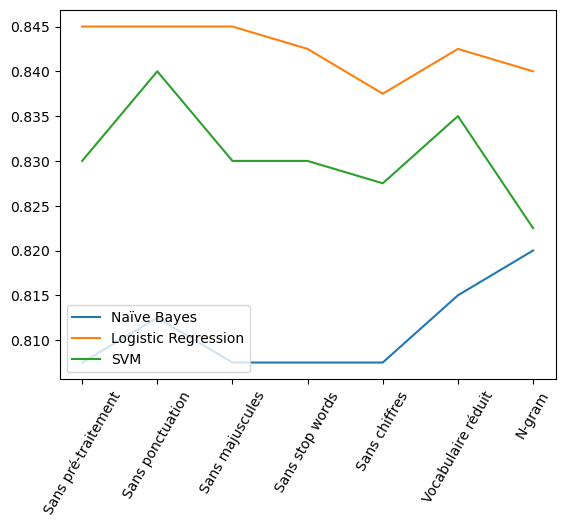

In [60]:
#Plots
plt.plot(preprocessing, NB_acc_score, label = 'Naïve Bayes')
plt.plot(preprocessing, LR_acc_score, label = 'Logistic Regression')
plt.plot(preprocessing, SVM_acc_score, label = 'SVM')
plt.legend(loc='lower left')
plt.xticks(rotation = 60)

In [61]:
#Selection des meilleurs pp et classifiers
index_NB = np.argmax(NB_acc_score) #Choisir un autre classifieur ?
index_LR = np.argmax(LR_acc_score)
index_SVM = np.argmax(SVM_acc_score)
print('Max NB : ', preprocessing[index_NB])
print('Max LR : ', preprocessing[index_LR])
print('Max SVM : ', preprocessing[index_SVM])
print('Max preprocessing and classifier : ', max(preprocessing[index_NB], preprocessing[index_LR], preprocessing[index_SVM]))

Max NB :  N-gram
Max LR :  Sans pré-traitement
Max SVM :  Sans ponctuation
Max preprocessing and classifier :  Sans pré-traitement


#### iv) Combinaison de prétraitements ? Classifieurs et Performances

### d) Save results

### e) Compléments Optionnels W2V

## 2. classification de locuteur sur des discours de Chirac et Mitterrand

**Analyses obligatoires**
- Comparer les performances avec différents pré-traitements
    - e.g Taille de vocabulaire, unigram/bigram, Stemming, ...
- Implémenter un post-traitement sur les données Chirac/mittérrand
- Appliquer les traitements optimaux sur les données de test et sauver les résultats dans un fichier txt

**Compléments optionnels**
- Analyser les performances avec Word2Vec, en utilisant des stratégies d'agrégation naïves
